# **_Import Libraries_**

---

---


In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from scipy import stats

# **_Load and Visualize Data_**

---

---


In [2]:
def load_and_visualize_graph(file_path, directed=True, weighted=False):
    if weighted:
        graph = nx.read_edgelist(file_path, create_using=nx.DiGraph() if directed else nx.Graph(), nodetype=str, data=(('weight', float),))
    else:
        graph = nx.read_edgelist(file_path, create_using=nx.DiGraph() if directed else nx.Graph(), nodetype=str)

    plt.figure(figsize=(8, 6))
    subgraph = graph.subgraph(list(graph.nodes)[:50])
    nx.draw(subgraph, with_labels=True, node_size=50, font_size=8, edge_color="gray")
    plt.title(f"Visualization of {file_path.split('/')[-1]}")
    plt.show()

    return graph

In [3]:
!pip install wget
import wget 

url1 = 'https://snap.stanford.edu/data/higgs-social_network.edgelist.gz'
url2 = 'https://snap.stanford.edu/data/higgs-retweet_network.edgelist.gz'
url3 = 'https://snap.stanford.edu/data/higgs-reply_network.edgelist.gz'
url4 = 'https://snap.stanford.edu/data/higgs-mention_network.edgelist.gz'

wget.download(url1, './higgs-social_network.edgelist.gz')
wget.download(url2, './higgs-retweet_network.edgelist.gz')
wget.download(url3, './higgs-reply_network.edgelist.gz')
wget.download(url4, './higgs-mention_network.edgelist.gz')

'./higgs-mention_network.edgelist (1).gz'

In [4]:
!gunzip higgs-social_network.edgelist.gz
!gunzip higgs-retweet_network.edgelist.gz
!gunzip higgs-reply_network.edgelist.gz
!gunzip higgs-mention_network.edgelist.gz

'gunzip' is not recognized as an internal or external command,
operable program or batch file.
'gunzip' is not recognized as an internal or external command,
operable program or batch file.
'gunzip' is not recognized as an internal or external command,
operable program or batch file.
'gunzip' is not recognized as an internal or external command,
operable program or batch file.


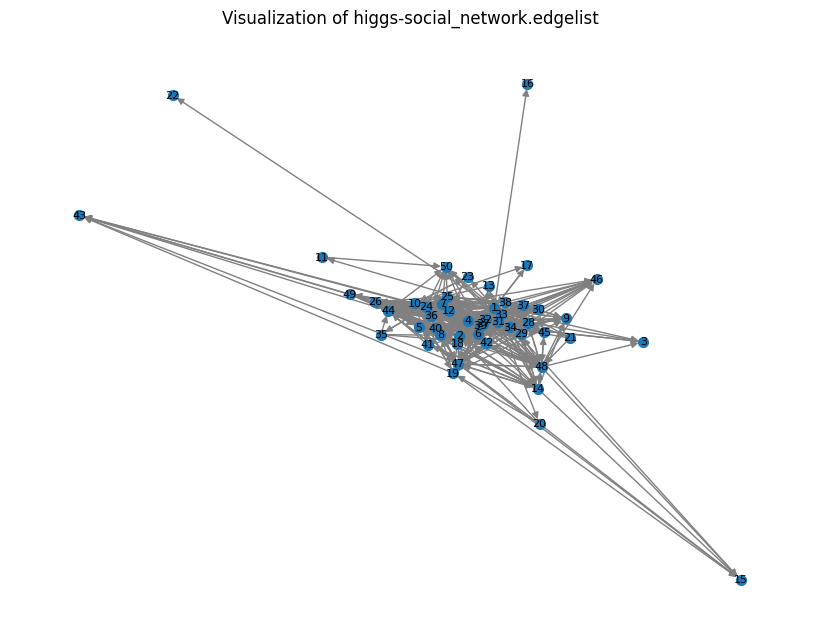

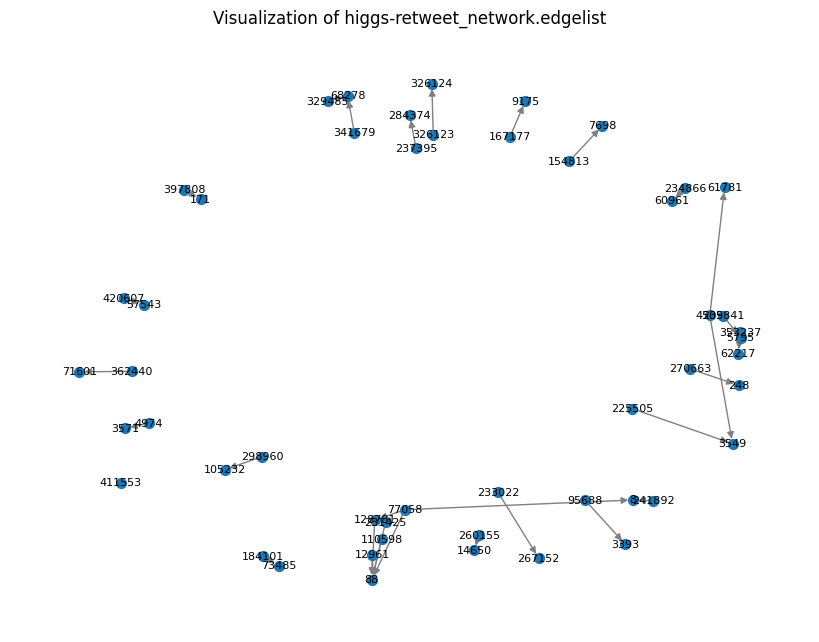

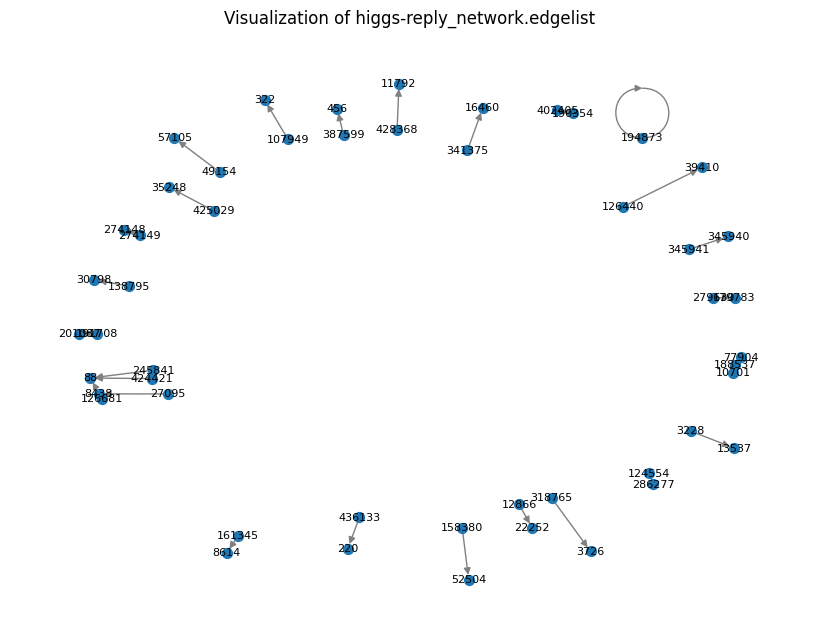

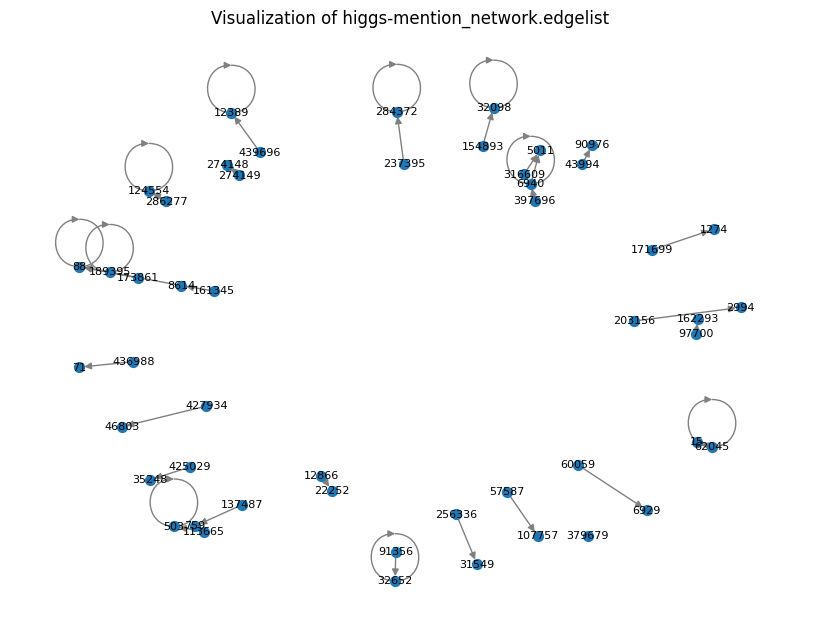

In [5]:
social_network_graph = load_and_visualize_graph("higgs-social_network.edgelist", directed=True, weighted=False)
retweet_graph = load_and_visualize_graph("higgs-retweet_network.edgelist", directed=True, weighted=True)
reply_graph = load_and_visualize_graph("higgs-reply_network.edgelist", directed=True, weighted=True)
mention_graph = load_and_visualize_graph("higgs-mention_network.edgelist", directed=True, weighted=True)

In [6]:
def count_edges_with_weights_greater_than_one(graph):
    count = 0
    for u, v, data in graph.edges(data=True):
        if 'weight' in data and data['weight'] > 1:
            count += 1
    return count

retweet_edges_gt1 = count_edges_with_weights_greater_than_one(retweet_graph)
reply_edges_gt1 = count_edges_with_weights_greater_than_one(reply_graph)
mention_edges_gt1 = count_edges_with_weights_greater_than_one(mention_graph)

print(f"Number of edges with weights > 1 in Retweet Graph: {retweet_edges_gt1}")
print(f"Number of edges with weights > 1 in Reply Graph: {reply_edges_gt1}")
print(f"Number of edges with weights > 1 in Mention Graph: {mention_edges_gt1}")

Number of edges with weights > 1 in Retweet Graph: 16918
Number of edges with weights > 1 in Reply Graph: 3047
Number of edges with weights > 1 in Mention Graph: 12445


# **_Calculate Metrics For Each User_**

---

---


In [7]:
def categorize_users_and_calculate_metrics(social_graph, retweet_graph, reply_graph, mention_graph):
    metrics = {
        "user": [],
        "initiation_metric": [],
        "spreading_metric": [],
        "receiving_metric": []
    }

    all_users = set(social_graph.nodes()).union(retweet_graph.nodes()).union(reply_graph.nodes()).union(mention_graph.nodes())

    for user in all_users:
        # Initiation Metric: Sum of weights of incoming edges in the retweet graph
        initiation_metric = 0
        if retweet_graph.has_node(user):
            initiation_metric = sum(
                retweet_graph[neighbor][user].get("weight", 1)
                for neighbor in retweet_graph.predecessors(user)
                if retweet_graph.has_edge(neighbor, user)
            )

        # Spreading Metric: Sum of weights of outgoing edges in the retweet graph
        spreading_metric = 0
        if retweet_graph.has_node(user):
            spreading_metric = retweet_graph.out_degree(user, weight="weight")

        # Receiving Metric: Sum of weights of incoming edges in the mention graph
        receiving_metric = 0
        if mention_graph.has_node(user):
            receiving_metric = mention_graph.in_degree(user, weight="weight")

        # Append metrics for the current user
        metrics["user"].append(user)
        metrics["initiation_metric"].append(initiation_metric)
        metrics["spreading_metric"].append(spreading_metric)
        metrics["receiving_metric"].append(receiving_metric)

    return pd.DataFrame(metrics)

In [8]:
metrics_df = categorize_users_and_calculate_metrics(social_network_graph, retweet_graph, reply_graph, mention_graph)
metrics_df.head()

,user,initiation_metric,spreading_metric,receiving_metric
0,429550,0.0,1.0,0.0
1,350957,0.0,0.0,0.0
2,240505,0.0,0.0,0.0
3,250702,0.0,1.0,0.0
4,439225,0.0,1.0,0.0


# **_Classify Users Based on Their Highest Metric_**

---

---


In [9]:
def classify_users_by_highest_metric(metrics_df):
    def classify(row):
        metrics = [row["initiation_metric"], row["spreading_metric"], row["receiving_metric"]]
        max_metric = max(metrics)
        if max_metric == row["initiation_metric"]:
            return "Initiator"
        elif max_metric == row["spreading_metric"]:
            return "Propagator"
        else:
            return "Receiver"

    metrics_df["category"] = metrics_df.apply(classify, axis=1)
    return metrics_df

In [10]:
classified_df = classify_users_by_highest_metric(metrics_df)
classified_df.head()

,user,initiation_metric,spreading_metric,receiving_metric,category
0,429550,0.0,1.0,0.0,Propagator
1,350957,0.0,0.0,0.0,Initiator
2,240505,0.0,0.0,0.0,Initiator
3,250702,0.0,1.0,0.0,Propagator
4,439225,0.0,1.0,0.0,Propagator


# **_Cluster Users with K-means Based on Metrics_**

---

---


In [11]:
def cluster_users_with_kmeans(metrics_df):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(metrics_df[["initiation_metric", "spreading_metric", "receiving_metric"]])

    kmeans = KMeans(n_clusters=3, random_state=42)
    metrics_df["cluster"] = kmeans.fit_predict(scaled_data)
    return metrics_df


In [12]:
clustered_df = cluster_users_with_kmeans(metrics_df)
clustered_df.head()

,user,initiation_metric,spreading_metric,receiving_metric,category,cluster
0,429550,0.0,1.0,0.0,Propagator,0
1,350957,0.0,0.0,0.0,Initiator,2
2,240505,0.0,0.0,0.0,Initiator,2
3,250702,0.0,1.0,0.0,Propagator,0
4,439225,0.0,1.0,0.0,Propagator,0


# **_Analyze and Visualize Results_**

---

---


In [13]:
def analyze_and_visualize_results(metrics_df):

    category_counts = metrics_df["category"].value_counts()
    print("User counts by category:")
    print(category_counts)


    category_counts.plot(kind="bar", title="User Category Distribution", color="skyblue")
    plt.xlabel("Category")
    plt.ylabel("Count")
    plt.show()


    cluster_counts = metrics_df["cluster"].value_counts()
    print("User counts by cluster:")
    print(cluster_counts)


    cluster_counts.plot(kind="bar", title="User Cluster Distribution", color="orange")
    plt.xlabel("Cluster")
    plt.ylabel("Count")
    plt.show()

User counts by category:
category
Initiator     224187
Propagator    216689
Receiver       15750
Name: count, dtype: int64


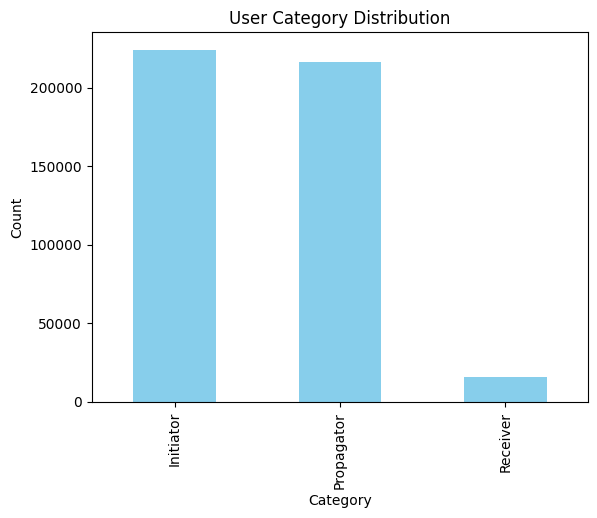

User counts by cluster:
cluster
2    228070
0    226777
1      1779
Name: count, dtype: int64


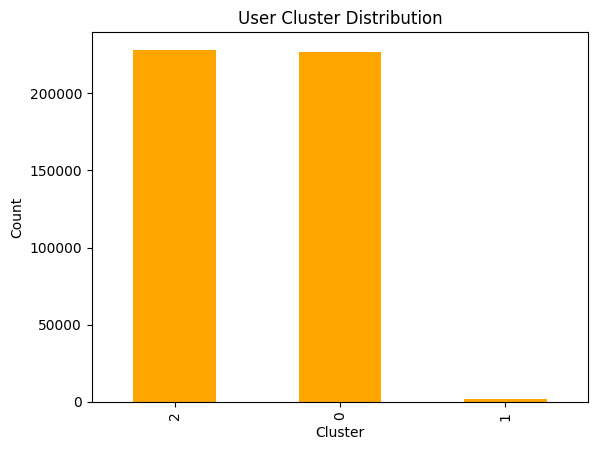

In [14]:
analyze_and_visualize_results(classified_df)

# **_Compute Centrality Measures_**

---

---


In [15]:
def compute_centrality_measures(graph, metrics_df):
    if nx.get_edge_attributes(graph, 'weight'):
        weight = "weight"
    else:
        weight = None

    # Compute Degree Centrality (with or without weight)
    # equation used: D = sum(weights of neighbours) / sum(weights of graph)
    if weight:
        total_weight = sum(
            data.get(weight, 1)
            for _, _, data in graph.edges(data=True)
        )
        # Compute degree centrality
        degree_centrality = {
            node: sum(graph[node][neighbor].get(weight, 1) for neighbor in graph.neighbors(node)) / total_weight
            for node in graph.nodes()
        }

    else:
        degree_centrality = nx.degree_centrality(graph)

    
    # Compute Closeness Centrality (with or without weight)
    
    if weight:
        closeness_centrality = nx.closeness_centrality(graph, distance='weight')
    else:
        closeness_centrality = nx.closeness_centrality(graph)

    

    metrics_dict = metrics_df.set_index('user')['spreading_metric'].to_dict()

    # Compute Local Centrality
    local_centrality = {}
    for node in graph.nodes():
        neighbors = list(graph.neighbors(node))
        if neighbors:
            # Use np.mean for efficient averaging
            sum_spreading = np.mean([metrics_dict.get(n, 0) for n in neighbors])
            local_centrality[node] = sum_spreading
        else:
            local_centrality[node] = 0

    centrality_df = pd.DataFrame({
        'Node': list(graph.nodes()),
        'Degree Centrality': [degree_centrality[node] for node in graph.nodes()],
        'Closeness Centrality': [closeness_centrality[node] for node in graph.nodes()],
        'Local User Centrality': [local_centrality[node] for node in graph.nodes()]
    })

    return centrality_df


# **_perform anova test_**

---

---


In [16]:
def perform_anova_test(centrality_df, classified_df):

    merged_df = pd.merge(centrality_df, classified_df[['user', 'category']],
                          left_on='Node', right_on='user')

    centrality_measures = ['Degree Centrality', 'Closeness Centrality', 'Local User Centrality']
    anova_results = {}

    for measure in centrality_measures:
        initiators = merged_df[merged_df['category'] == 'Initiator'][measure]
        receivers = merged_df[merged_df['category'] == 'Receiver'][measure]
        propagators = merged_df[merged_df['category'] == 'Propagator'][measure]

        f_statistic, p_value = stats.f_oneway(initiators, receivers, propagators)

        anova_results[measure] = {
            'F-statistic': f_statistic,
            'p-value': p_value,
            'Significant': p_value < 0.05
        }

    return anova_results

# **_analyze anova results_**

---

---


In [17]:
def analyze_anova_results(anova_results):
    print("ANOVA Test Results:")
    for measure, results in anova_results.items():
        print(f"\n{measure}:")
        print(f"F-statistic: {results['F-statistic']:.4f}")
        print(f"p-value: {results['p-value']:.4f}")
        print(f"Statistically Significant: {results['Significant']}")

        if results['Significant']:
            print("Conclusion: Reject null hypothesis. This centrality measure can distinguish between user categories.")
        else:
            print("Conclusion: Fail to reject null hypothesis. This centrality measure may not effectively distinguish between user categories.")

# **_Best Centerality Measure_**

---

---


In [18]:
def identify_best_centrality_measure(classified_df, centrality_results):
    merged_df = pd.merge(classified_df, centrality_results, left_on='user', right_on='Node')
    propagators = merged_df[merged_df['category'] == 'Propagator']

    evaluation_metrics = {}
    centrality_measures = ['Degree Centrality', 'Closeness Centrality', 'Local User Centrality']
    for measure in centrality_measures:

        top_propagators = propagators.sort_values(measure, ascending=False)

        total_propagators = len(propagators)
        top_20_percent = int(total_propagators * 0.2)
        top_20_propagators = top_propagators.head(top_20_percent)

        recall = len(top_20_propagators) / total_propagators

        concentration = len(top_20_propagators) / len(top_propagators)

        evaluation_metrics[measure] = {
            'Recall': recall,
            'Concentration': concentration,
            'Top 20% Propagators': len(top_20_propagators),
            'Total Propagators': total_propagators
        }

    best_measure = max(evaluation_metrics, key=lambda x: evaluation_metrics[x]['Recall'] * evaluation_metrics[x]['Concentration'])

    print("\nCentrality Measure Evaluation for Identifying Propagators:\n")
    for measure, metrics in evaluation_metrics.items():
        print(f"{measure}:")
        print(f"  Recall: {metrics['Recall']:.2%}")
        print(f"  Concentration: {metrics['Concentration']:.2%}")
        print(f"  Top 20% Propagators: {metrics['Top 20% Propagators']} out of {metrics['Total Propagators']}")
        print()

    print(f"\nBest Centrality Measure for Identifying Propagators: {best_measure}")
    print("Explanation:")
    print("- Recall: Percentage of propagators captured in top nodes")
    print("- Concentration: How densely propagators are distributed in top nodes")

    return best_measure, evaluation_metrics



# **_Compare Centerality across Graphs_**

---

---


In [19]:
def compare_centrality_across_graphs(social_network_graph, retweet_graph, reply_graph, mention_graph, metrics_df, classified_df):
    graphs = {
        "Social Network Graph": social_network_graph,
        "Retweet Graph": retweet_graph,
        "Reply Graph": reply_graph,
        "Mention Graph": mention_graph
    }

    best_measures = {}

    print("Comparative Centrality Analysis Across Different Graphs:\n")

    for graph_name, graph in graphs.items():
        print(f"\n--- Analysis for {graph_name} ---")

        # Compute centrality measures
        centrality_results = compute_centrality_measures(graph, metrics_df)

        # Perform ANOVA test
        anova_results = perform_anova_test(centrality_results, classified_df)

        # Analyze and print ANOVA results
        analyze_anova_results(anova_results)

        # Identify best centrality measure
        best_measure, metrics = identify_best_centrality_measure(classified_df, centrality_results)
        best_measures[graph_name] = best_measure

        # Create DataFrame for top 5 centralities
        top_5_degree = centrality_results[['Node', 'Degree Centrality']].sort_values('Degree Centrality', ascending=False).head(5)
        top_5_closeness = centrality_results[['Node', 'Closeness Centrality']].sort_values('Closeness Centrality', ascending=False).head(5)
        top_5_local = centrality_results[['Node', 'Local User Centrality']].sort_values('Local User Centrality', ascending=False).head(5)

        # Print DataFrame for each centrality measure
        print("\nTop 5 Nodes by Degree Centrality:")
        print(top_5_degree)
        
        print("\nTop 5 Nodes by Closeness Centrality:")
        print(top_5_closeness)
        
        print("\nTop 5 Nodes by Local User Centrality:")
        print(top_5_local)

    # Summarize best measures across graphs
    print("\nBest Centrality Measures Across Graphs:")
    for graph, measure in best_measures.items():
        print(f"{graph}: {measure}")


In [20]:
compare_centrality_across_graphs(social_network_graph, retweet_graph, reply_graph, mention_graph, metrics_df, classified_df)

Comparative Centrality Analysis Across Different Graphs:


--- Analysis for Social Network Graph ---
ANOVA Test Results:

Degree Centrality:
F-statistic: 1346.8987
p-value: 0.0000
Statistically Significant: True
Conclusion: Reject null hypothesis. This centrality measure can distinguish between user categories.

Local User Centrality:
F-statistic: 1214.0347
p-value: 0.0000
Statistically Significant: True
Conclusion: Reject null hypothesis. This centrality measure can distinguish between user categories.

Centrality Measure Evaluation for Identifying Propagators:

Degree Centrality:
  Recall: 20.00%
  Concentration: 20.00%
  Top 20% Propagators: 43337 out of 216689

Local User Centrality:
  Recall: 20.00%
  Concentration: 20.00%
  Top 20% Propagators: 43337 out of 216689


Best Centrality Measure for Identifying Propagators: Degree Centrality
Explanation:
- Recall: Percentage of propagators captured in top nodes
- Concentration: How densely propagators are distributed in top nodes

Top 